# IMPORTING USEFUL LIBRARIES

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from matplotlib import pyplot as plt
import math

In [2]:
#spark = SparkSession.builder.master("local[*]").appName("SparkDFbasic").getOrCreate()

In [3]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf = conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
from pyspark.sql import functions as F
from pyspark.sql import *
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql import types
from pyspark.sql.functions import min, max ,to_timestamp,col, unix_timestamp, to_date
from pyspark.sql import Window
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

In [5]:
spark

# WORKING WITH DATA

## Reading the data into pyspark dataframes

In [6]:
item_categoriesDf = spark.read.csv('item_categories.csv', header = True, inferSchema = True)
itemsDf = spark.read.csv('items.csv', header = True, inferSchema = True)
sales_trainDf = spark.read.csv('sales_train.csv',header=True,inferSchema=True)
sales_testDf = spark.read.csv('test.csv', header = True, inferSchema = True)
shopsDf = spark.read.csv('shops.csv', header = True, inferSchema = True)

In [7]:
item_categoriesDf.show(10)
itemsDf.show(10)
sales_trainDf.show(10)
sales_testDf.show(10)
shopsDf.show(10)

+--------------------+----------------+
|  item_category_name|item_category_id|
+--------------------+----------------+
|PC - Гарнитуры/На...|               0|
|    Аксессуары - PS2|               1|
|    Аксессуары - PS3|               2|
|    Аксессуары - PS4|               3|
|    Аксессуары - PSP|               4|
| Аксессуары - PSVita|               5|
|Аксессуары - XBOX...|               6|
|Аксессуары - XBOX...|               7|
|      Билеты (Цифра)|               8|
|     Доставка товара|               9|
+--------------------+----------------+
only showing top 10 rows

+--------------------+-------+----------------+
|           item_name|item_id|item_category_id|
+--------------------+-------+----------------+
|! ВО ВЛАСТИ НАВАЖ...|      0|              40|
|!ABBYY FineReader...|      1|              76|
|***В ЛУЧАХ СЛАВЫ ...|      2|              40|
|***ГОЛУБАЯ ВОЛНА ...|      3|              40|
|***КОРОБКА (СТЕКЛ...|      4|              40|
|***НОВЫЕ АМЕРИКАН...|      5|

## Data types of various fields in the data frames

Lets have a look at the data types of all the fields in our data frames.

In [8]:
print("item_categories datatypes: %s" %item_categoriesDf.dtypes)
print("\nitems datatypes: %s" %itemsDf.dtypes)
print("\nsales_train datatypes: %s" %sales_trainDf.dtypes)
print("\nsales_test datatypes: %s" %sales_testDf.dtypes)
print("\nshops datatypes: %s" %shopsDf.dtypes)

item_categories datatypes: [('item_category_name', 'string'), ('item_category_id', 'int')]

items datatypes: [('item_name', 'string'), ('item_id', 'string'), ('item_category_id', 'string')]

sales_train datatypes: [('date', 'string'), ('date_block_num', 'int'), ('shop_id', 'int'), ('item_id', 'int'), ('item_price', 'double'), ('item_cnt_day', 'double')]

sales_test datatypes: [('ID', 'int'), ('shop_id', 'int'), ('item_id', 'int')]

shops datatypes: [('shop_name', 'string'), ('shop_id', 'int')]


It can be seen that the datatype of date column in sales_train is string. I will convert in into the format YYYY-MM-DDD so that i can later order my data by the date.

In [9]:
sales_trainDf = sales_trainDf.withColumn('date',to_date(unix_timestamp(col('date'), 'dd.mm.yyyy').cast("timestamp")))

In [10]:
sales_trainDf.show(5)

+----------+--------------+-------+-------+----------+------------+
|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|
+----------+--------------+-------+-------+----------+------------+
|2013-01-02|             0|     59|  22154|     999.0|         1.0|
|2013-01-03|             0|     25|   2552|     899.0|         1.0|
|2013-01-05|             0|     25|   2552|     899.0|        -1.0|
|2013-01-06|             0|     25|   2554|   1709.05|         1.0|
|2013-01-15|             0|     25|   2555|    1099.0|         1.0|
+----------+--------------+-------+-------+----------+------------+
only showing top 5 rows



## Combining dataframes

To combine the information present in more 5 different dataframes, we can join the tables using the join function based on similar columns.

In [11]:
Sales_trainDf = sales_trainDf.join(itemsDf, on='item_id').join(shopsDf, on='shop_id').join(item_categoriesDf, on='item_category_id')
Sales_trainDf.show(10)
print("Total number of rows: %d" %Sales_trainDf.count())

+----------------+-------+-------+----------+--------------+----------+------------+--------------------+--------------------+--------------------+
|item_category_id|shop_id|item_id|      date|date_block_num|item_price|item_cnt_day|           item_name|           shop_name|  item_category_name|
+----------------+-------+-------+----------+--------------+----------+------------+--------------------+--------------------+--------------------+
|              37|     59|  22154|2013-01-02|             0|     999.0|         1.0|   ЯВЛЕНИЕ 2012 (BD)|"Ярославль ТЦ ""А...|      Кино - Blu-Ray|
|              58|     25|   2552|2013-01-03|             0|     899.0|         1.0|DEEP PURPLE  The ...|"Москва ТРК ""Атр...|      Музыка - Винил|
|              58|     25|   2552|2013-01-05|             0|     899.0|        -1.0|DEEP PURPLE  The ...|"Москва ТРК ""Атр...|      Музыка - Винил|
|              58|     25|   2554|2013-01-06|             0|   1709.05|         1.0|DEEP PURPLE  Who ...|"Москва

This new table shows us all the information about each item. It shows that a certain item belonging to a certain category was sold by a certain shop on a specific date. <br>
For our future sales prediction, the text based fields in our dataframe such as shop's names, item's names etc. are not so useful so it might be better if we drop these columns

In [12]:
Sales_trainDf = Sales_trainDf[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
Sales_trainDf.show(10)

+----------+--------------+-------+----------------+-------+----------+------------+
|      date|date_block_num|shop_id|item_category_id|item_id|item_price|item_cnt_day|
+----------+--------------+-------+----------------+-------+----------+------------+
|2013-01-02|             0|     59|              37|  22154|     999.0|         1.0|
|2013-01-03|             0|     25|              58|   2552|     899.0|         1.0|
|2013-01-05|             0|     25|              58|   2552|     899.0|        -1.0|
|2013-01-06|             0|     25|              58|   2554|   1709.05|         1.0|
|2013-01-15|             0|     25|              56|   2555|    1099.0|         1.0|
|2013-01-10|             0|     25|              59|   2564|     349.0|         1.0|
|2013-01-02|             0|     25|              56|   2565|     549.0|         1.0|
|2013-01-04|             0|     25|              55|   2572|     239.0|         1.0|
|2013-01-11|             0|     25|              55|   2572|     

In [13]:
Sales_trainDf.select(min("date")).show(1)
Sales_trainDf.select(max("date")).show(1)

+----------+
| min(date)|
+----------+
|2013-01-01|
+----------+

+----------+
| max(date)|
+----------+
|2015-01-31|
+----------+



In the above lines of codes it can be seen that the data spans over a period of 33 months. Therefore, we need to make sure that in this dataframe, no such item exists which is not present in our test data. All those items which are present in this dataframe but are not there in or test data are no longer availble in shops. Similarly, all those shops which are present here but are not there in our test data should also be removed because they might be closed during the course of 33 months.

In [14]:
test_itemIdsDf = sales_testDf.select('item_id').distinct()
test_shopIdsDf = sales_testDf.select('shop_id').distinct()
Sales_trainDf = Sales_trainDf.join(test_itemIdsDf, on = "item_id").join(test_shopIdsDf, on = "shop_id")
Sales_trainDf.show(10)
print("Total number of rows: %d" %Sales_trainDf.count())

+-------+-------+----------+--------------+----------------+----------+------------+
|shop_id|item_id|      date|date_block_num|item_category_id|item_price|item_cnt_day|
+-------+-------+----------+--------------+----------------+----------+------------+
|     59|  22154|2013-01-02|             0|              37|     999.0|         1.0|
|     25|   2574|2013-01-03|             0|              55|     399.0|         2.0|
|     25|   2574|2013-01-05|             0|              55|     399.0|         1.0|
|     25|   2574|2013-01-07|             0|              55|     399.0|         1.0|
|     25|   2574|2013-01-08|             0|              55|     399.0|         2.0|
|     25|   2574|2013-01-10|             0|              55|     399.0|         1.0|
|     25|   2574|2013-01-11|             0|              55|     399.0|         2.0|
|     25|   2574|2013-01-13|             0|              55|     399.0|         1.0|
|     25|   2574|2013-01-16|             0|              55|     

It can be seen that initially we had 2925510 rows but now our data has been reduced to 1221909 rows

In order to calculate some usefule features that mighthelp me in implementing my regression model, I have applied some sql queries to the dataframe.

In [15]:
Sales_trainDf.createOrReplaceTempView("sales")


In [16]:
featuresDf = spark.sql("Select shop_id,item_id,date_block_num,item_category_id,avg(item_price) as averageItemPrice,sum(item_price) as sumItemPrice, sum(item_cnt_day) as sumItemCount, avg(item_cnt_day) as meanItemCount,count(item_cnt_day) as transactions from sales group by shop_id,item_id,date_block_num,item_category_id")
featuresDf.show()

+-------+-------+--------------+----------------+----------------+------------+------------+------------------+------------+
|shop_id|item_id|date_block_num|item_category_id|averageItemPrice|sumItemPrice|sumItemCount|     meanItemCount|transactions|
+-------+-------+--------------+----------------+----------------+------------+------------+------------------+------------+
|     59|  22154|             0|              37|           999.0|       999.0|         1.0|               1.0|           1|
|     25|   2574|             0|              55|           399.0|      3990.0|        13.0|               1.3|          10|
|     25|   2607|             0|              55|           279.0|       558.0|         2.0|               1.0|           2|
|     25|   2614|             0|              55|           299.0|       598.0|         2.0|               1.0|           2|
|     25|   2808|             0|              30|           999.0|     17982.0|        30.0|1.6666666666666667|          18|


#### Fields in the dataframe featuresDf

1. shop_id: The identifier of a shop
2. item_id: The identifier of an item
3. date_block_num: month block in which transaction took place (0 means the transaction tookplace in Jan 2013
4. item_category_id: The identifier of item category
5. averageItemPrice: The average item price of all the items belonging to one group. For example, in the first row, <br>
   the average price of all the items with item_id of 7856 sold by the shop with shop_id 18 in Jan 2013 is 767
6. sumItemPrice: The sum of the prices of all the items belonging to one group. For example, in the first row, <br>
   the sum of the prices of all the items with item_id of 7856 sold by the shop with shop_id 18 in Jan 2013 is 7670
7. sumItemCount: It is basically the total number of items sold belonging to one group. For example, in the first row, <br>
   the total number of items of item_id 7856 sold by the shop with shop_id 18 in Jan 2013 is 13.
8. meanItemCount: It is basically the mean of the items sold in each transaction. For example, in the first row <br>
   the meanItemCount is 1.3 which means that in each transation, an average of 1.3 items were sold
9. transaction: The total number of transactions of a certain group. It must be noted that the transactionscan be less <br>
   sumItemCount beacuse more than 1 items can be sold per transaction.

In [17]:
featuresDf.createOrReplaceTempView("features")

In [18]:
spark.sql("select * from features").show(7)

+-------+-------+--------------+----------------+----------------+------------+------------+------------------+------------+
|shop_id|item_id|date_block_num|item_category_id|averageItemPrice|sumItemPrice|sumItemCount|     meanItemCount|transactions|
+-------+-------+--------------+----------------+----------------+------------+------------+------------------+------------+
|     59|  22154|             0|              37|           999.0|       999.0|         1.0|               1.0|           1|
|     25|   2574|             0|              55|           399.0|      3990.0|        13.0|               1.3|          10|
|     25|   2607|             0|              55|           279.0|       558.0|         2.0|               1.0|           2|
|     25|   2614|             0|              55|           299.0|       598.0|         2.0|               1.0|           2|
|     25|   2808|             0|              30|           999.0|     17982.0|        30.0|1.6666666666666667|          18|


Since the data I am working on is of various software firms, it might be posssible that in future, a certain shop starts selling an item which it was previously not selling. To make a dataframe of all the combinations of shops and items, I created three RDDs of shopIds, itemIds and dateblocks, took their cartesian product and finally formed a new dataframe with my resultant rdd.

In [19]:
shopIds = featuresDf.select('shop_id').distinct().collect()
itemIds = featuresDf.select('item_id').distinct().collect()
dateBlock = range(0,34)

shopIdsRdd = sc.parallelize(shopIds)
itemIdsRdd = sc.parallelize(itemIds)
dateBlockRdd = sc.parallelize(dateBlock)

possiblePairRdd = shopIdsRdd.cartesian(itemIdsRdd).cartesian(dateBlockRdd).map(lambda x: (x[0][0].__getitem__('shop_id'),x[0][1].__getitem__('item_id'),x[1]))
print(possiblePairRdd.count())

6697320


In [20]:
possiblePairRdd.take(5)

[(59, 22154, 0), (59, 2574, 0), (59, 2607, 0), (59, 2614, 0), (59, 2808, 0)]

In [21]:
possiblePairDf = possiblePairRdd.toDF(['shop_id','item_id','date_block_num'])

In [22]:
possiblePairDf.show()
possiblePairDf.count()

+-------+-------+--------------+
|shop_id|item_id|date_block_num|
+-------+-------+--------------+
|     59|  22154|             0|
|     59|   2574|             0|
|     59|   2607|             0|
|     59|   2614|             0|
|     59|   2808|             0|
|     59|   2703|             0|
|     59|   2088|             0|
|     59|   2090|             0|
|     59|   2100|             0|
|     59|   2164|             0|
|     59|   2252|             0|
|     59|   2254|             0|
|     59|   2461|             0|
|     59|   2678|             0|
|     59|   2416|             0|
|     59|   2235|             0|
|     59|   3168|             0|
|     59|   3268|             0|
|     59|   3394|             0|
|     59|   3141|             0|
+-------+-------+--------------+
only showing top 20 rows



6697320

In [23]:
possiblePairDf.show()

+-------+-------+--------------+
|shop_id|item_id|date_block_num|
+-------+-------+--------------+
|     59|  22154|             0|
|     59|   2574|             0|
|     59|   2607|             0|
|     59|   2614|             0|
|     59|   2808|             0|
|     59|   2703|             0|
|     59|   2088|             0|
|     59|   2090|             0|
|     59|   2100|             0|
|     59|   2164|             0|
|     59|   2252|             0|
|     59|   2254|             0|
|     59|   2461|             0|
|     59|   2678|             0|
|     59|   2416|             0|
|     59|   2235|             0|
|     59|   3168|             0|
|     59|   3268|             0|
|     59|   3394|             0|
|     59|   3141|             0|
+-------+-------+--------------+
only showing top 20 rows



Now I can join this data fram with my featuresDf. Here I am setting all the values that will be used in my regression model to 0 rather than leaving them null

In [24]:
featuresDf = possiblePairDf.join(featuresDf, on=['date_block_num','shop_id','item_id'], how='left')
featuresDf = featuresDf.fillna(0, subset=['averageItemPrice', 'sumItemPrice', 'sumItemCount', 'meanItemCount','transactions'])
featuresDf.show()

+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+
|date_block_num|shop_id|item_id|item_category_id|averageItemPrice|sumItemPrice|sumItemCount|meanItemCount|transactions|
+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+
|             0|      2|    656|            null|             0.0|         0.0|         0.0|          0.0|           0|
|             0|      2|    784|            null|             0.0|         0.0|         0.0|          0.0|           0|
|             0|      2|   1409|              19|          1398.5|      1398.5|         1.0|          1.0|           1|
|             0|      2|   1988|            null|             0.0|         0.0|         0.0|          0.0|           0|
|             0|      2|   2191|            null|             0.0|         0.0|         0.0|          0.0|           0|
|             0|      2|   2283|        

In [25]:
featuresDf.count()

6697320

In [28]:
xDf = featuresDf.join(itemsDf.drop('item_name'), on =['item_id','item_category_id'], how = 'left')
xDf.show(5)
xDf.count()

+-------+----------------+--------------+-------+----------------+------------+------------+-------------+------------+
|item_id|item_category_id|date_block_num|shop_id|averageItemPrice|sumItemPrice|sumItemCount|meanItemCount|transactions|
+-------+----------------+--------------+-------+----------------+------------+------------+-------------+------------+
|    656|            null|             0|      2|             0.0|         0.0|         0.0|          0.0|           0|
|    784|            null|             0|      2|             0.0|         0.0|         0.0|          0.0|           0|
|   1409|              19|             0|      2|          1398.5|      1398.5|         1.0|          1.0|           1|
|   1988|            null|             0|      2|             0.0|         0.0|         0.0|          0.0|           0|
|   2191|            null|             0|      2|             0.0|         0.0|         0.0|          0.0|           0|
+-------+----------------+--------------

6697320

In [29]:
featuresDf.describe().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+
|summary|   date_block_num|           shop_id|           item_id|  item_category_id| averageItemPrice|     sumItemPrice|       sumItemCount|      meanItemCount|       transactions|
+-------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+
|  count|          6697320|           6697320|           6697320|            599279|          6697320|          6697320|            6697320|            6697320|            6697320|
|   mean|             16.5|31.642857142857142|11062.818763326226| 42.50588790863688|81.54443559747342|188.0900024715003|0.24090412284316712|0.09767599494245824|0.18244745659457812|
| stddev|9.810709167609772| 17.56189380671925| 6199.583010722853|17.745794446372308|536.0037535

In [26]:
monthCalculator = F.udf(lambda x: (x % 12)+1, IntegerType())
yearCalculator = F.udf(lambda x: ((x//12) + 2013), IntegerType())
featuresDf = featuresDf.withColumn("month", monthCalculator(featuresDf.date_block_num))
featuresDf = featuresDf.withColumn("year", yearCalculator(featuresDf.date_block_num))

featuresDf.show(10)

+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+-----+----+
|date_block_num|shop_id|item_id|item_category_id|averageItemPrice|sumItemPrice|sumItemCount|meanItemCount|transactions|month|year|
+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+-----+----+
|             0|      2|    656|            null|             0.0|         0.0|         0.0|          0.0|           0|    1|2013|
|             0|      2|    784|            null|             0.0|         0.0|         0.0|          0.0|           0|    1|2013|
|             0|      2|   1409|              19|          1398.5|      1398.5|         1.0|          1.0|           1|    1|2013|
|             0|      2|   1988|            null|             0.0|         0.0|         0.0|          0.0|           0|    1|2013|
|             0|      2|   2191|            null|             0.0|         0.0|    

In [31]:
print("total number of rows: %d" %featuresDf.count())

total number of rows: 6697320


### Exception Handling

For execption handing, I removed all the data where sum of the number of items was negative or where price was greater than 400000

In [27]:
featuresDf = featuresDf.filter('sumItemCount >= 0 and sumItemPrice < 400000')
featuresDf.show()
print("total number of rows: %d" %featuresDf.count())

+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+-----+----+
|date_block_num|shop_id|item_id|item_category_id|averageItemPrice|sumItemPrice|sumItemCount|meanItemCount|transactions|month|year|
+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+-----+----+
|             0|      2|    656|            null|             0.0|         0.0|         0.0|          0.0|           0|    1|2013|
|             0|      2|    784|            null|             0.0|         0.0|         0.0|          0.0|           0|    1|2013|
|             0|      2|   1409|              19|          1398.5|      1398.5|         1.0|          1.0|           1|    1|2013|
|             0|      2|   1988|            null|             0.0|         0.0|         0.0|          0.0|           0|    1|2013|
|             0|      2|   2191|            null|             0.0|         0.0|    

In [28]:
newFeaturesDf = featuresDf

It can be seen that the data has been reduced from 6697320 rows to 6693610

## Finalizing Features

As implemeted below, I have added some more useful features including the itemsales of the past three month in each group.

In [29]:
newFeaturesDf = newFeaturesDf.withColumn("item_cnt_month", F.lag("sumItemCount",1).over(Window.partitionBy("shop_id", "item_id").orderBy("date_block_num")))
newFeaturesDf = newFeaturesDf.withColumn('item_cnt_mean', F.avg('sumItemCount').over(Window.partitionBy("shop_id", "item_category_id", "item_id").orderBy("date_block_num").rangeBetween(-2,0)))
newFeaturesDf = newFeaturesDf.withColumn('item_cnt_std', F.stddev('sumItemCount').over(Window.partitionBy("shop_id", "item_category_id", "item_id").orderBy("date_block_num").rangeBetween(-2,0)))
newFeaturesDf = newFeaturesDf.withColumn("item_cnt_month_prev1", F.lag("sumItemCount",1).over(Window.partitionBy("shop_id", "item_category_id", "item_id").orderBy("date_block_num")))
newFeaturesDf = newFeaturesDf.withColumn("item_cnt_month_prev2", F.lag("sumItemCount",2).over(Window.partitionBy("shop_id", "item_category_id", "item_id").orderBy("date_block_num")))
newFeaturesDf = newFeaturesDf.withColumn("item_cnt_month_prev3", F.lag("sumItemCount",3).over(Window.partitionBy("shop_id", "item_category_id", "item_id").orderBy("date_block_num")))
newFeaturesDf = newFeaturesDf.fillna(0)

In [30]:
newFeaturesDf.show()

+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+-----+----+--------------+-------------+------------+--------------------+--------------------+--------------------+
|date_block_num|shop_id|item_id|item_category_id|averageItemPrice|sumItemPrice|sumItemCount|meanItemCount|transactions|month|year|item_cnt_month|item_cnt_mean|item_cnt_std|item_cnt_month_prev1|item_cnt_month_prev2|item_cnt_month_prev3|
+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+-----+----+--------------+-------------+------------+--------------------+--------------------+--------------------+
|             0|      2|   3239|            null|             0.0|         0.0|         0.0|          0.0|           0|    1|2013|           0.0|          0.0|         0.0|                 0.0|                 0.0|                 0.0|
|             1|      2|   3239|            null|       

Now let's split the data into train, validation and test sets.

In [31]:
train_set = newFeaturesDf.filter(newFeaturesDf['date_block_num'] >= 3).filter(newFeaturesDf['date_block_num'] < 28) 
validation_set = newFeaturesDf.filter(newFeaturesDf['date_block_num'] >= 28).filter(newFeaturesDf['date_block_num'] < 33)
test_set = newFeaturesDf.filter(newFeaturesDf['date_block_num'] == 33)
train_set.dropna(subset=['item_cnt_month'])
validation_set.dropna(subset=['item_cnt_month'])
train_set.dropna()
validation_set.dropna()
totalsize = newFeaturesDf.count()
trainsize = train_set.count()
validsize = validation_set.count()
testsize = test_set.count()
print('Size of the Train set: %d' %trainsize)
print('Size of the Validation set: %d' %validsize)
print('Size of the test set: %d' %testsize)

Size of the Train set: 4924310
Size of the Validation set: 984844
Size of the test set: 196973


To improve my results, I have added more features like the total number of items sold by each shop and total items sold each month

In [32]:
train_set = train_set.withColumn('itemByShopMean', F.avg('item_cnt_month').over(Window.partitionBy("shop_id")))
train_set = train_set.withColumn('monthlyItemMean', F.avg('item_cnt_month').over(Window.partitionBy("item_id")))
validation_set = validation_set.withColumn('itemByShopMean', F.avg('item_cnt_month').over(Window.partitionBy("shop_id")))
validation_set = validation_set.withColumn('monthlyItemMean', F.avg('item_cnt_month').over(Window.partitionBy("item_id")))
test_set = test_set.withColumn('itemByShopMean', F.avg('item_cnt_month').over(Window.partitionBy("shop_id")))
test_set = test_set.withColumn('monthlyItemMean', F.avg('item_cnt_month').over(Window.partitionBy("item_id")))
test_set.show(5)

+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+-----+----+--------------+-------------+------------+--------------------+--------------------+--------------------+-------------------+---------------+
|date_block_num|shop_id|item_id|item_category_id|averageItemPrice|sumItemPrice|sumItemCount|meanItemCount|transactions|month|year|item_cnt_month|item_cnt_mean|item_cnt_std|item_cnt_month_prev1|item_cnt_month_prev2|item_cnt_month_prev3|     itemByShopMean|monthlyItemMean|
+--------------+-------+-------+----------------+----------------+------------+------------+-------------+------------+-----+----+--------------+-------------+------------+--------------------+--------------------+--------------------+-------------------+---------------+
|            33|     26|    474|            null|             0.0|         0.0|         0.0|          0.0|           0|   10|2015|           0.0|          0.0|         0.0|            

Since we dont require the date_block num column because this information is already available in the form of month and year.<br>
To finalize the test set I have join my testSet with the original table of test sales available.

In [33]:
trainSet = train_set.drop('date_block_num')
testSet = test_set.drop('date_block_num', 'item_cnt_month')
validationSet = validation_set.drop('date_block_num')


test = sales_testDf.join(testSet, on=['shop_id', 'item_id'], how="full")
test = test.fillna(0)
test.drop('ID')

DataFrame[shop_id: bigint, item_id: bigint, item_category_id: string, averageItemPrice: double, sumItemPrice: double, sumItemCount: double, meanItemCount: double, transactions: bigint, month: int, year: int, item_cnt_mean: double, item_cnt_std: double, item_cnt_month_prev1: double, item_cnt_month_prev2: double, item_cnt_month_prev3: double, itemByShopMean: double, monthlyItemMean: double]

In [34]:
trainSet.drop('item_category_id')
testSet.drop('item_category_id')
validationSet.drop('item_category_id')


finalFeatures = ['shop_id', 'item_id', 'sumItemCount', 'transactions', 'year', 'meanItemCount', 'item_cnt_std', 'item_cnt_month_prev1','item_cnt_month_prev2','item_cnt_month_prev3', 'item_cnt_month']
train = trainSet[finalFeatures]
validation = validationSet[finalFeatures]
testFeatures = ['shop_id', 'item_id', 'sumItemCount', 'transactions', 'year', 'meanItemCount', 'item_cnt_std', 'item_cnt_month_prev1','item_cnt_month_prev2','item_cnt_month_prev3']

In [43]:
train.show(5)

+-------+-------+------------+------------+----+-------------+------------+--------------------+--------------------+--------------------+--------------+
|shop_id|item_id|sumItemCount|transactions|year|meanItemCount|item_cnt_std|item_cnt_month_prev1|item_cnt_month_prev2|item_cnt_month_prev3|item_cnt_month|
+-------+-------+------------+------------+----+-------------+------------+--------------------+--------------------+--------------------+--------------+
|      2|   3239|         0.0|           0|2013|          0.0|         0.0|                 0.0|                 0.0|                 0.0|           0.0|
|      2|   3239|         0.0|           0|2013|          0.0|         0.0|                 0.0|                 0.0|                 0.0|           0.0|
|      2|   3239|         0.0|           0|2013|          0.0|         0.0|                 0.0|                 0.0|                 0.0|           0.0|
|      2|   3239|         0.0|           0|2013|          0.0|         0.0| 

# Linear Regression

In [146]:
from pyspark.ml.regression import LinearRegression
startTime=time.time()
assembler = VectorAssembler(inputCols=['shop_id', 'item_id', 'transactions', 'year', 'meanItemCount', 'item_cnt_std', 'item_cnt_month_prev1','item_cnt_month_prev2','item_cnt_month_prev3'], outputCol="features")
transformed = assembler.transform(train)

lr = LinearRegression(featuresCol="features", labelCol="item_cnt_month",maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrtest = testSet[testFeatures]
# Fit the model
lrModel = lr.fit(transformed)
lr_val_pred = lrModel.transform(assembler.transform(validation))
predictions = lrModel.transform(assembler.transform(lrtest))
predictions = predictions.join(sales_testDf, ['item_id', 'shop_id'])
#predictions.show()
lr_train_pred = lrModel.transform(transformed)
evaluator = RegressionEvaluator(labelCol = "item_cnt_month", predictionCol="prediction", metricName="rmse")
Rmsetrain = evaluator.evaluate(lr_train_pred)
Rmsevalid = evaluator.evaluate(lr_val_pred)
TimeTaken = time.time()-startTime
print("train RMSE: %g" %Rmsetrain)
print("validation RMSE: %g" %Rmsevalid)
print("execution time: %g" %TimeTaken)

train RMSE:  0.518654
validation RMSE: 0.582873
execution time:  360.322


# Decision Tree Regression

In [194]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

startTime=time.time()
# Load the data stored in LIBSVM format as a DataFrame.
assembler = VectorAssembler(inputCols=['shop_id', 'item_id', 'transactions', 'year', 'meanItemCount', 'item_cnt_std', 'item_cnt_month_prev1','item_cnt_month_prev2','item_cnt_month_prev3'], outputCol="features")
transformed = assembler.transform(train)
# data = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")
dt = DecisionTreeRegressor(featuresCol="features", labelCol="item_cnt_month",maxDepth=5, maxBins=32)
dttest = testSet[testFeatures]
# Fit the model
dtModel = dt.fit(transformed)
dt_val_pred = dtModel.transform(assembler.transform(validation))
predictions = dtModel.transform(assembler.transform(dttest))
predictions = predictions.join(sales_testDf, ['item_id', 'shop_id'])
#predictions.show()
dt_train_pred = dtModel.transform(transformed)
evaluator = RegressionEvaluator(labelCol = "item_cnt_month", predictionCol="prediction", metricName="rmse")
Rmsevalid = evaluator.evaluate(dt_val_pred)
Rmsetrain = evaluator.evaluate(dt_train_pred)
TimeTaken = time.time()-startTime
print("train RMSE: %g" %Rmsetrain)
print("validation RMSE: %g" %Rmsevalid)
print("execution time: %g" %TimeTaken)

train RMSE: 0.415686
validation RMSE: 0.48784
execution time: 367.302


# Random Forest Regression

In [161]:
timeAr = []
TrainRmseAr=[]
ValidRmseAr=[]
FeatureImpAr=[]

import time
i=10
while i<101:
    startTime = time.time()
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml.feature import VectorAssembler
    assembler = VectorAssembler(inputCols=['shop_id', 'item_id', 'transactions', 'year', 'meanItemCount', 'item_cnt_std', 'item_cnt_month_prev1','item_cnt_month_prev2','item_cnt_month_prev3'], outputCol="features")
    transformed = assembler.transform(train)
    rf = RandomForestRegressor(featuresCol="features", labelCol="item_cnt_month").setNumTrees(i)
    i+=10
    Rftest = testSet[testFeatures]

    #Rftest.show(10)


    #Rftest.count()
    Rfmodel = rf.fit(transformed)
    FeatureImpAr.append((Rfmodel.featureImportances))
    #print("Feature Importances: " + str(Rfmodel.featureImportances))
    rf_val_pred = Rfmodel.transform(assembler.transform(validation))
    predictions = Rfmodel.transform(assembler.transform(Rftest))
    predictions = predictions.join(sales_testDf, ['item_id', 'shop_id'])
    
    rf_train_pred = Rfmodel.transform(transformed)
    from pyspark.ml.evaluation import RegressionEvaluator
    evaluator = RegressionEvaluator(labelCol = "item_cnt_month", predictionCol="prediction", metricName="rmse")
    Rmsetrain = evaluator.evaluate(rf_train_pred)
    TrainRmseAr.append(Rmsetrain)
    
    Rmsevalid = evaluator.evaluate(rf_val_pred)
    ValidRmseAr.append(Rmsevalid)
    
    TimeTaken = time.time()-startTime
    timeAr.append(TimeTaken)
    
    print(i)



20
30
40
50
60
70
80
90
100
110


In [56]:
noOfTrees=[i*10 for i in range(1,11)]
noOfTrees

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [164]:
print(timeAr)
print(TrainRmseAr)
print(ValidRmseAr)

[330.54, 332.3331229686737, 367.43903493881226, 442.246474981308, 474.5559809207916, 664.1641280651093, 654.7197799682617, 690.0897490978241, 738.5123546513548, 874.0400269031525]
[0.4128531851365478, 0.4078541659225135, 0.402584621354872, 0.402125844544523, 0.402522354847231, 0.401079578616773, 0.4006486564852689, 0.40017034299753707, 0.40068051988585746, 0.4002342196314401]
[0.4801710862283941, 0.4780006020988954, 0.4750542187566113, 0.4741315632018453, 0.4746486564852689, 0.472614853258792, 0.4714313495242122, 0.4715481606562385, 0.4712034821354232, 0.471492168745621]


In [61]:
import matplotlib.pyplot as plt

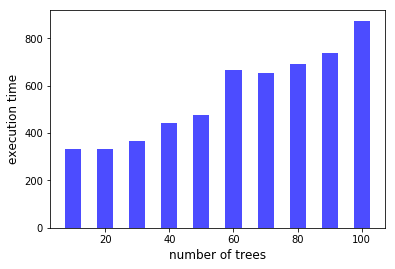

In [63]:
plt.bar(noOfTrees,timeAr, align = 'center', width=5, alpha=0.7,color='blue')
plt.xlabel('number of trees', fontsize=12)
plt.ylabel('execution time', fontsize=12)
plt.show()

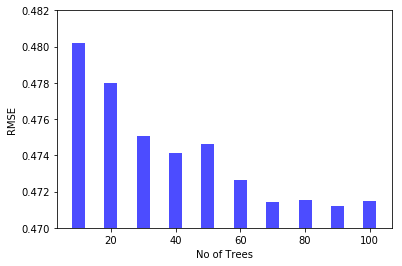

In [64]:
plt.bar(noOfTrees,ValidRmseAr,align='center',width=4,color='blue',alpha=0.7)
plt.ylim(0.47,0.482)
plt.xlabel('No of Trees')
plt.ylabel('RMSE')
plt.show()

In [77]:
columns=['shop_id', 'item_id', 'transactions', 'year', 'meanItemCount', 'item_cnt_std', 'item_cnt_month_prev1','item_cnt_month_prev2','item_cnt_month_prev3']

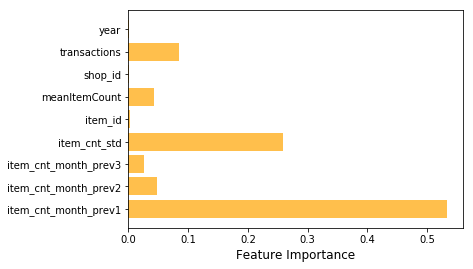

In [167]:
plt.barh(columns,FeatureImpAr[6],alpha=0.7,color='orange')
plt.xlabel('Feature Importance', fontsize=12)
plt.show()

Now let's vary the maximum depth and observe output

In [ ]:
import time
TimeArr=[]
RmsetrainArr=[]
RmsevalidArr=[]
FeatureImpArr=[]
i=3
while i<16:
    startTime = time.time()
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml.feature import VectorAssembler
    assembler = VectorAssembler(inputCols=['shop_id', 'item_id', 'transactions', 'year', 'meanItemCount', 'item_cnt_std', 'item_cnt_month_prev1','item_cnt_month_prev2','item_cnt_month_prev3'], outputCol="features")
    transformed = assembler.transform(train)
    rf = RandomForestRegressor(featuresCol="features", labelCol="item_cnt_month").setNumTrees(70).setMaxDepth(i)
    i+=2
    Rftest = testSet[testFeatures]

    #Rftest.show(10)


    #Rftest.count()
    Rfmodel = rf.fit(transformed)
    FeatureImpArr.append((Rfmodel.featureImportances))
    #print("Feature Importances: " + str(Rfmodel.featureImportances))
    rf_val_pred = Rfmodel.transform(assembler.transform(validation))
    predictions = Rfmodel.transform(assembler.transform(Rftest))
    predictions = predictions.join(sales_testDf, ['item_id', 'shop_id'])
    #predictions.show()
    rf_train_pred = Rfmodel.transform(transformed)
    from pyspark.ml.evaluation import RegressionEvaluator
    evaluator = RegressionEvaluator(labelCol = "item_cnt_month", predictionCol="prediction", metricName="rmse")
    Rmsetrain = evaluator.evaluate(rf_train_pred)
    RmsetrainArr.append(Rmsetrain)
    #print("Training data Root Mean Squared Error: %g" % Rmsetrain)
    Rmsevalid = evaluator.evaluate(rf_val_pred)
    RmsevalidArr.append(Rmsevalid)
    #print("Validation data Root Mean Squared Error: %g" % Rmsevalid)
    TimeTaken = time.time()-startTime
    TimeArr.append(TimeTaken)
    #print("Time taken for job completion: %g" %TimeTaken)
    print(i)


5
7
9
11
13
15
17


In [129]:
print(TimeArr)
print(RmsetrainArr)
print(RmsevalidArr)
print(FeatureImpArr)

[433.27674198150635, 533.9125940799713, 719.2549269199371, 927.32137799263, 1501.2445168495178, 2134.420378923416, 3349.5383689403534]
[0.496142547854236, 0.404387956154784, 0.400215484684518, 0.3992377704239595, 0.3890470044048509, 0.3810851028470186, 0.37514183672026363]
[0.55152331548768, 0.471215478845321, 0.468451235487964, 0.466845135748568, 0.46546766794051314, 0.46279936411644174, 0.46203669947633247]
[SparseVector(9, {0: 0.0, 1: 0.0003, 2: 0.0934, 3: 0.0001, 4: 0.0589, 5: 0.3166, 6: 0.4484, 7: 0.0539, 8: 0.0284}), SparseVector(9, {0: 0.0001, 1: 0.0005, 2: 0.0868, 3: 0.0004, 4: 0.0473, 5: 0.283, 6: 0.5049, 7: 0.0503, 8: 0.0267}), SparseVector(9, {0: 0.0002, 1: 0.0007, 2: 0.0857, 3: 0.0007, 4: 0.0447, 5: 0.2689, 6: 0.5255, 7: 0.0478, 8: 0.0257}), SparseVector(9, {0: 0.0007, 1: 0.0013, 2: 0.0849, 3: 0.001, 4: 0.0437, 5: 0.2631, 6: 0.5323, 7: 0.0477, 8: 0.0253}), SparseVector(9, {0: 0.0017, 1: 0.0021, 2: 0.0844, 3: 0.0013, 4: 0.0434, 5: 0.2597, 6: 0.5341, 7: 0.048, 8: 0.0253}), Sp

In [124]:
depthArr=[i for i in range(3,16,2)]
depthArr

[3, 5, 7, 9, 11, 13, 15]

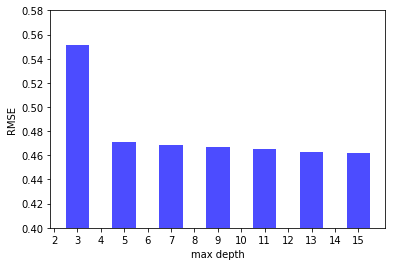

In [142]:
plt.bar(depthArr,RmsevalidArr,align='center',width=1,color='blue',alpha=0.7)
plt.xticks(np.arange(2,16))
plt.ylim(0.40,0.58)
plt.xlabel('max depth')
plt.ylabel('RMSE')
plt.show()

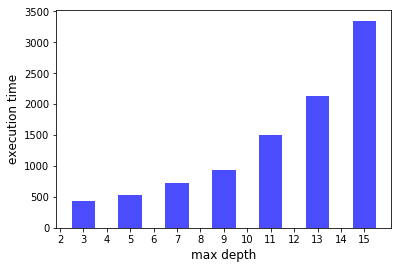

In [143]:
plt.bar(depthArr,TimeArr, align = 'center', width=1, alpha=0.7,color='blue')
plt.xticks(np.arange(2,16))
plt.xlabel('max depth', fontsize=12)
plt.ylabel('execution time', fontsize=12)
plt.show()

# Gradient Boostedd Tree Regression

In [42]:
import time
from pyspark.ml.regression import GBTRegressor
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.ml.feature import VectorAssembler


# Load the data stored in LIBSVM format as a DataFrame.
assembler = VectorAssembler(inputCols=['shop_id', 'item_id', 'transactions', 'year', 'meanItemCount', 'item_cnt_std', 'item_cnt_month_prev1','item_cnt_month_prev2','item_cnt_month_prev3'], outputCol="features")
transformed = assembler.transform(train)
# data = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")
gbt = GBTRegressor(featuresCol="features", labelCol="item_cnt_month",maxIter=70)
gbttest = testSet[testFeatures]
# Fit the model
gbtModel = gbt.fit(transformed)
gbt_val_pred = gbtModel.transform(assembler.transform(validation))
predictions = gbtModel.transform(assembler.transform(gbttest))
predictions = predictions.join(sales_testDf, ['item_id', 'shop_id'])
#predictions.show()

gbt_train_pred = gbtModel.transform(transformed)
evaluator = RegressionEvaluator(labelCol = "item_cnt_month", predictionCol="prediction", metricName="rmse")
Rmsevalid = evaluator.evaluate(gbt_val_pred)
TimeTaken = time.time()-startTime
print("train RMSE: %g" %Rmsetrain)
print("validation RMSE: %g" %Rmsevalid)
print("execution time: %g" %TimeTaken)


train RMSE: 0.408354
validation RMSE: 0.461454
execution time: 5596.71


# Results

The following lines of code can be applied after each algorithm to get the predicted results

In [ ]:
predictions = predictions.join(sales_test, ['item_id', 'shop_id'])
predictions.show()

In [159]:
predictions = predictions.orderBy("ID")
predictions.show()

+-------+-------+------------+------------+----+-------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---+
|item_id|shop_id|sumItemCount|transactions|year|meanItemCount|      item_cnt_std|item_cnt_month_prev1|item_cnt_month_prev2|item_cnt_month_prev3|            features|         prediction| ID|
+-------+-------+------------+------------+----+-------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---+
|   5037|      5|         0.0|           0|2015|          0.0|               0.0|                 0.0|                 0.0|                 0.0|(9,[0,1,3],[5.0,5...|0.13160801036054562|  0|
|   5233|      5|         1.0|           1|2015|          1.0|1.1547005383792517|                 3.0|                 1.0|                 2.0|[5.0,5233.0,1.0,2...| 2.8856431858171705|  2|
|   5232|      5|         0.0|           0|2015|  

In [213]:
predictedSales = predictions.select(F.col("ID"), F.col("Prediction").alias("item_cnt_month")).orderBy(F.col("ID"))
predictedSales.show()

+---+-------------------+
| ID|     item_cnt_month|
+---+-------------------+
|  0|0.15388505255635387|
|  2| 2.9311865305409643|
|  3|0.15388505255635387|
|  5|0.33423855141020176|
|  6| 2.4519852254982615|
|  7|0.15388505255635387|
|  8|0.15620483699644694|
|  9|0.15388505255635387|
| 10| 1.9661599219794166|
| 11|0.15050119283278407|
| 12| 0.1612968487255355|
| 13|0.15050119283278407|
| 14|  2.008735427529381|
| 15|  1.046350273390873|
| 16|0.15050119283278407|
| 17| 0.1590970522394575|
| 18| 1.2428001918385971|
| 19|0.15050119283278407|
| 20|0.36639961884694905|
| 21|0.15388505255635387|
+---+-------------------+
only showing top 20 rows

